In [1]:
# Include so results on different machines are (should be) the same.
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
!jupyter nbconvert --to script Keras_BagnallCharacter_RNN.ipynb

[NbConvertApp] Converting notebook Keras_BagnallCharacter_RNN.ipynb to script
[NbConvertApp] Writing 11226 bytes to Keras_BagnallCharacter_RNN.py


In [34]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = ["Barack Obama",
          "Donald J. Trump",
          "Dwight D. Eisenhower",
          "Franklin D. Roosevelt",
          "George Bush",
          "George W. Bush",
#          "Gerald R. Ford",
          "Harry S. Truman",
#          "Herbert Hoover",
          "Jimmy Carter",
          "John F. Kennedy",
          "Lyndon B. Johnson",
          "Richard Nixon",
          "Ronald Reagan",
          "William J. Clinton"]
labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {"Obama": "Barack Obama", 
                     "Trump": "Donald J. Trump",
                     "Eisenhower": "Dwight D. Eisenhower",
                     "Roosevelt": "Franklin D. Roosevelt",
                     "Bush": "George Bush",
                     "WBush": "George W. Bush",
#                     "Ford": "Gerald R. Ford",
                     "Truman": "Harry S. Truman",
#                     "Hoover": "Herbert Hoover",
                     "Carter": "Jimmy Carter",
                     "Kennedy": "John F. Kennedy",
                     "Johnson": "Lyndon B. Johnson",
                     "Nixon": "Richard Nixon",
                     "Reagan": "Ronald Reagan",
                     "Clinton": "William J. Clinton"
                    }

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 25 speeches for 2 presidents.
Loaded 1435 speeches for 13 presidents.


In [35]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_\n"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    #"Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '', loaded_text[x])
    #"...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]', '7', loaded_text[x])
    #"...any character with a frequency lower than 1 in 10,000 is discarded." (+ \n)
    loaded_text[x] = loaded_text[x].translate(trantab)
    #"Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

print "Replacements complete."

Replacements complete.


In [36]:
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

# compress all speeches down into one massive per president
compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4891166
1  : Donald J. Trump      	445782
2  : Dwight D. Eisenhower 	3109439
3  : Franklin D. Roosevelt 	2125124
4  : George Bush          	1922344
5  : George W. Bush       	1763481
6  : Harry S. Truman      	2066478
7  : Jimmy Carter         	1294669
8  : John F. Kennedy      	1352086
9  : Lyndon B. Johnson    	2356175
10 : Richard Nixon        	992093
11 : Ronald Reagan        	987802
12 : William J. Clinton   	1762034

Minimum number of characters per president?
445782


In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

unique_chars = len(tokenizer.word_counts)

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Unique char count: 66

Chars w/ counts:
[(4497030, ' '), (2450414, 'e'), (2033706, 't'), (1549204, 'o'), (1531378, 'a'), (1408772, 'n'), (1336422, 'i'), (1138825, 's'), (1100960, 'r'), (1017877, 'h'), (717297, 'l'), (674129, 'd'), (524147, 'u'), (506926, 'c'), (452461, 'm'), (402150, 'w'), (375828, 'g'), (369501, 'f'), (361094, 'p'), (358432, 'y'), (266698, 'b'), (259049, '.'), (254447, ','), (226984, 'v'), (169322, 'I'), (145733, 'k'), (95687, "'"), (85163, '7'), (69999, 'A'), (62624, 'T'), (58505, 'S'), (42713, '-'), (39923, 'W'), (34953, 'N'), (32800, 'C'), (32236, 'E'), (31326, 'x'), (30287, 'P'), (27134, 'M'), (24669, 'B'), (24321, 'j'), (21883, 'R'), (20959, 'H'), (20485, 'q'), (18639, 'D'), (17793, 'G'), (17238, 'O'), (14935, 'U'), (12348, 'F'), (11775, ':'), (11417, 'L'), (11171, 'z'), (10683, '"'), (10496, '?'), (10052, 'Y'), (9480, ';'), (8199, 'J'), (4691, 'V'), (4551, 'Q'), (4350, 'K'), (3474, '$'), (1824, '/'), (424, 'Z'), (361, '\\'), (318, 'X'), (1, '}')]


In [39]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 50

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print split_labels[1000:1003]
print split_text[1000:1003]
print "Sample, label sizes:", len( split_text ), len( split_labels )
split_size = len( split_text ) / max_seq_len
print "\nTotal split groups:", split_size, "= (",len( split_text ),"/",max_seq_len,")"


[0, 0, 0]
[[8, 1, 21, 13, 12, 17, 2, 3, 23, 1, 16, 2, 1, 16, 7, 11, 11, 1, 2, 6, 12, 1, 2, 12, 13, 14, 5, 3, 7, 4, 6, 1, 19, 9, 4, 17, 9, 5, 15, 8, 1, 3, 10, 5, 3, 1, 12, 4, 6, 3], [1, 16, 4, 9, 26, 1, 5, 6, 12, 1, 2, 6, 12, 1, 12, 7, 9, 2, 14, 3, 1, 19, 5, 20, 15, 2, 6, 3, 8, 1, 3, 4, 1, 11, 5, 9, 17, 2, 1, 5, 17, 9, 7, 21, 13, 8, 7, 6, 2, 8], [8, 2, 8, 1, 3, 10, 5, 3, 1, 12, 4, 6, 3, 1, 6, 2, 2, 12, 1, 3, 10, 2, 15, 22, 1, 33, 2, 11, 11, 1, 2, 11, 7, 15, 7, 6, 5, 3, 2, 1, 3, 10, 2, 1, 6, 4, 32, 21, 7, 12]]
Sample, label sizes: 501366 501366

Total split groups: 10027 = ( 501366 / 50 )


In [21]:
# split amongst speaker samples, not the whole population of samples
def split_test_train(input_text, input_labels, labels, train_pct=0.8):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))
        
        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]
        
    return train_text,train_labels,test_text,test_labels

In [22]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical

#  
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.8)

print "Splits: test = ", len(train_X), "train = ", len(test_X)

# one-hot encode classes
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

Splits: test =  401087 train =  100279


In [23]:
#custom activation from Bagnall 2015
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less_equal(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout
from keras.optimizers import Adagrad, adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

# define operating vars
batch_size = 100
epochs = 100

# define optimizer
optimizer = Adagrad(lr=0.01)

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5,
              patience=1, verbose=1)
csv_logger = CSVLogger('Keras_BagnallCharacterRNN_training.log')
early_stop = EarlyStopping(monitor='categorical_accuracy',
                           min_delta=0.01,
                           verbose=1,
                           patience=3)

# assemble & compile model
print('Build model...')
model = Sequential()
model.add(Embedding(unique_chars+1,100,input_length=max_seq_len))
model.add(SimpleRNN(100,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))


model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])
print(model.summary())

# train
model.fit(train_X, 
          train_y, 
          batch_size=batch_size, 
          epochs=epochs,
          callbacks=[reduce_lr, csv_logger, early_stop],
          verbose=1)


model.save('Keras_BagnallCharacterRNN_training.h5')  
del model

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           6700      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1313      
Total params: 28,113
Trainable params: 28,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
401087/401087 [==============================] - 130s - loss: 2.3857 - categorical_accuracy: 0.2098   
Epoch 2/100
401087/401087 [==============================] - 127s - loss: 2.3037 - categorical_accuracy: 0.2355   
Epoch 3/100
401087/401087 [==============================] - 128s - loss: 2.2631 - categorical_accuracy: 0.2554   
Epoch 4/100
401087/401087 [==========

In [25]:
#----------------
#----------------

In [29]:
# Load computed model
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('Keras_BagnallCharacterRNN_training.h5')

In [30]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
100096/100279 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[2.1767857090667149, 0.28969175998962893]

Predicting using test data...
100000/100279 [============================>.] - ETA: 0sDone prediction.


Confusion matrix, without normalization
[43721     0 32202  1434  2615    55 12218    15     0  8016     3     0
     0]
[[14717     0  3296    66   435    19   370     2     0   660     0     0
      0]
 [ 1065     0   377    21   127     5   103     0     0    85     0     0
      0]
 [ 2884     0  7266    48   127     0  1397     0     0   716     0     0
      0]
 [ 2273     0  3641   947    83     1   897     0     0   659     0     0
      0]
 [ 4277     0  1661    38   633     7   562     0     0   512     0     0
      0]
 [ 4796     0  1239    38   337    14   302     0     0   328     0     0
      0]
 [ 1059     0  2459    75   186     0  3778     0     0   709     0     0
      0]
 [ 2298     0  1681    28   123     1   372     3     0   672     1     0
      0]
 [ 1542     0  2251    22    79     2   852     1     0   660     0     0
      0]
 [ 1849     0  3331    93    46     0  2406     6     0  1692     2     0
      0]
 [  839     0  1783    20    30     0   683     3

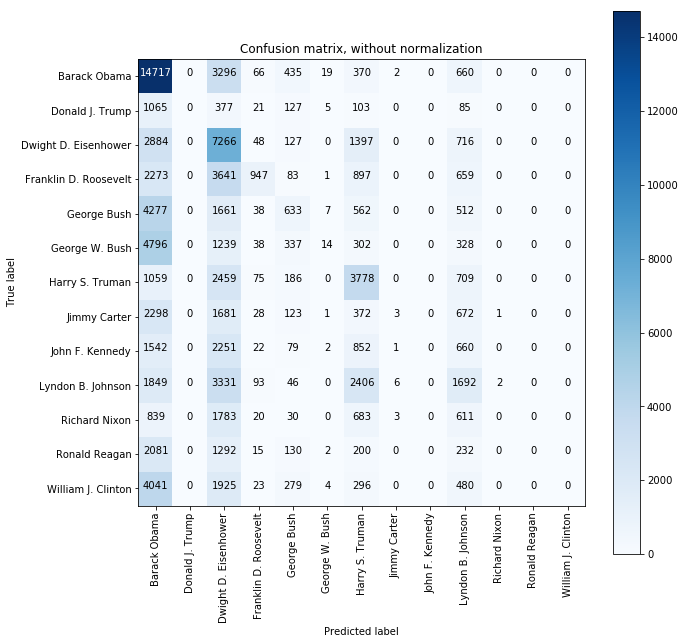

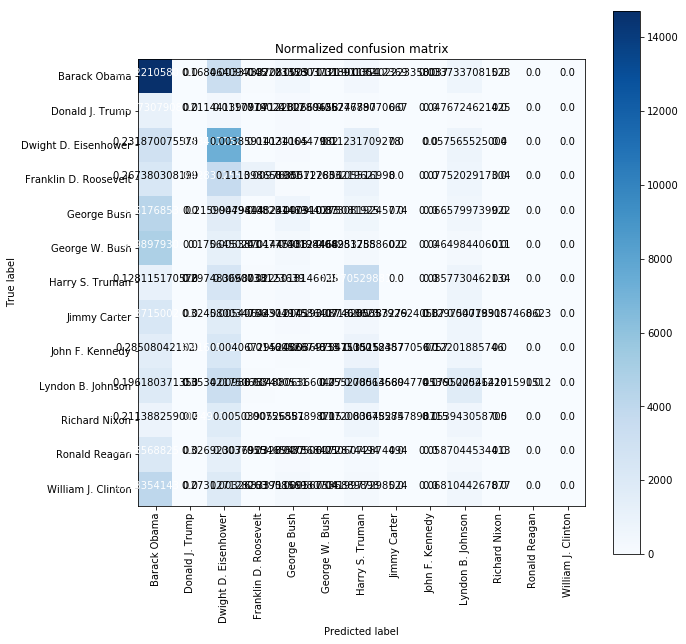

In [33]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(np.sum(cm,axis=0))

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()